In [1]:
!wget -O CPDDVRestClassV402.ipynb https://raw.githubusercontent.com/Db2-DTE-POC/CPDDVLAB/master/CPDDVRestClassV402.ipynb
%run CPDDVRestClassV402.ipynb

--2021-12-03 14:19:50--  https://raw.githubusercontent.com/Db2-DTE-POC/CPDDVLAB/master/CPDDVRestClassV402.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15020 (15K) [text/plain]
Saving to: ‘CPDDVRestClassV402.ipynb’

CPDDVRestClassV402. 100%[===================>]  14.67K  --.-KB/s    in 0s      

2021-12-03 14:19:50 (53.5 MB/s) - ‘CPDDVRestClassV402.ipynb’ saved [15020/15020]



In [2]:
# Set the service URL to connect from inside the ICPD Cluster
Console  = 'https://cpd-cpd-instance.apps.demo.ibmdte.net:31192'

# Connect to the Db2 Data Management Console service
user     = 'admin'
password = 'CP4DDataFabric'

# Set up the required connection
databaseAPI = Db2(Console)
api = '/v1'
databaseAPI.authenticate(api, user, password)
database = Console

Token Retrieved


In [ ]:
### Display Virtualized Tables and Views 
display(databaseAPI.getVirtualizedTablesDF())
display(databaseAPI.getVirtualizedViewsDF())

In [3]:
df = databaseAPI.getCaches('Enabled')
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

,id,name,state,size,cardinality,last_refresh_timestamp
1,DV20211110165634403313,BOEING737,Enabled,56967,4172450,2021-11-10 18:30:21.411623
2,DV20211115151427714635,ONTIME737NJCA,Enabled,554,37621,2021-11-15 15:33:30.254003
5,DV20211110144113849337,ONTIME0910,Enabled,591398,12752436,2021-11-10 16:32:41.327378
7,DV20211115221309388288,AIRCRAFT,Enabled,106,13101,2021-12-02 21:59:34.515222
9,DV2021110817343042456,ChurnAll,Enabled,363,7043,2021-12-02 21:54:01.289865
10,DV20211110144049703423,ONTIME1115,Enabled,1399806,30190408,2021-11-10 15:01:13.967413


In [ ]:
df = databaseAPI.getCaches('Disabled')
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

In [ ]:
# Enable ONTIME1115
databaseAPI.enableCache('DV20211110144113849337')

In [ ]:
# Enable ONTIME0910
databaseAPI.enableCache('DV20211110144049703423')

In [ ]:
# Enable AIRCRAFT
databaseAPI.enableCache('DV20211115221309388288')

In [ ]:
# Enable BOEING737
databaseAPI.enableCache('DV20211110165634403313')

In [ ]:
# Enable ONTIME737NJCA
databaseAPI.enableCache('DV20211115151427714635')

In [4]:
!wget -O db2.ipynb https://raw.githubusercontent.com/Db2-DTE-POC/Db2-Openshift-11.5.4/master/db2.ipynb
%run db2.ipynb
print('db2.ipynb loaded')

--2021-12-03 14:20:04--  https://raw.githubusercontent.com/Db2-DTE-POC/Db2-Openshift-11.5.4/master/db2.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168432 (164K) [text/plain]
Saving to: ‘db2.ipynb’

db2.ipynb           100%[===================>] 164.48K  --.-KB/s    in 0.005s  

2021-12-03 14:20:04 (31.2 MB/s) - ‘db2.ipynb’ saved [168432/168432]

Db2 Extensions Loaded.
db2.ipynb loaded


In [5]:
# Connect to the Data Virtualization Database from inside of IBM Cloud Pak for Data
database = 'bigsql'
user = 'admin'
password = 'CP4DDataFabric'
host = 'cpd-cpd-instance.apps.demo.ibmdte.net'
port = '31193'

%sql CONNECT TO {database} USER {user} USING {password} HOST {host} PORT {port}

Connection successful.


In [6]:
ontime0910count = %sql SELECT COUNT(*) FROM ONTIME.ONTIME0910;

In [7]:
ontime1115count = %sql SELECT COUNT(*) FROM ONTIME.ONTIME1115;

In [8]:
ontime737count = %sql SELECT COUNT(*) FROM ONTIME.BOEING737;

In [9]:
ontimenjca737count = %sql SELECT COUNT(*) FROM ONTIME.ONTIME737NJCA;

In [10]:
aircraftcount = %sql SELECT COUNT(*) FROM ONTIME.AIRCRAFT;

In [11]:
ontime0910 = ontime0910count['1'][0]
ontime1115 = ontime1115count['1'][0]
ontimefull = ontime0910 + ontime1115
ontime737 = ontime737count['1'][0]
ontimenjca737 = ontimenjca737count['1'][0]
aircraft = aircraftcount['1'][0]

In [12]:
print('Aircraft:' + str(aircraft))
print('Number of Domestic Flights in the US')
print('Years 2009 to 2010: ' + str(ontime0910))
print('Years 2011 to 2015: ' + str(ontime1115))
print('Years 2009 to 2015: ' + str(ontimefull))
print('Only 737 from 2009 to 2015: ' + str(ontime737))
print('Only 737 from NJ to CA: ' + str(ontimenjca737))

Aircraft:13101.0
Number of Domestic Flights in the US
Years 2009 to 2010: 12752436.0
Years 2011 to 2015: 30190408.0
Years 2009 to 2015: 42942844.0
Only 737 from 2009 to 2015: 4172450.0
Only 737 from NJ to CA: 37621.0


In [45]:
# Disable ONTIME0910
databaseAPI.disableCache('DV20211110144113849337')

Cache: DV20211110144113849337 disabled.


In [46]:
# Disable ONTIME1115
databaseAPI.disableCache('DV20211110144049703423')

Cache: DV20211110144049703423 disabled.


In [47]:
# Disable BOEING737
databaseAPI.disableCache('DV20211110165634403313')

Cache: DV20211110165634403313 disabled.


In [48]:
# Disable ONTIME737NJCA
databaseAPI.disableCache('DV20211115151427714635')

Cache: DV20211115151427714635 disabled.


In [49]:
# Disable AIRCRAFT
databaseAPI.disableCache('DV20211115221309388288')

Cache: DV20211115221309388288 disabled.


In [18]:
df = databaseAPI.getCaches('Enabled')
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

,id,name,state,size,cardinality,last_refresh_timestamp
9,DV2021110817343042456,ChurnAll,Enabled,363,7043,2021-12-02 21:54:01.289865


In [19]:
%%sql 
SELECT * FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 2000
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

,DAYKEY,YEAR,QUARTERKEY,QUARTER,MONTHKEY,MONTH,DAYOFMONTH,DAYOFWEEK,FLIGHTDATE,UNIQUECARRIER,AIRLINEID,CARRIER,TAILNUM,FLIGHTNUM,ORIGINAIRPORTID,ORIGINAIRPORTSEQID,ORIGINCITYMARKETID,ORIGIN,ORIGINCITYNAME,ORIGINSTATE,ORIGINSTATEFIPS,ORIGINSTATENAME,ORIGINWAC,DESTAIRPORTID,DESTAIRPORTSEQID,DESTCITYMARKETID,DEST,DESTCITYNAME,DESTSTATE,DESTSTATEFIPS,DESTSTATENAME,DESTWAC,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDELAYMINUTES,DEPDEL15,DEPARTUREDELAYGROUPS,DEPTIMEBLK,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,ARRDELAYMINUTES,ARRDEL15,ARRIVALDELAYGROUPS,ARRTIMEBLK,CANCELLED,CANCELLATIONCODE,DIVERTED,CRSELAPSEDTIME,ACTUALELAPSEDTIME,AIRTIME,FLIGHTS,DISTANCE,DISTANCEGROUP,CARRIERDELAY,WEATHERDELAY,NASDELAY,SECURITYDELAY,LATEAIRCRAFTDELAY,FIRSTDEPTIME,TOTALADDGTIME,LONGESTADDGTIME,DIVAIRPORTLANDINGS,DIVREACHEDDEST,DIVACTUALELAPSEDTIME,DIVARRDELAY,DIVDISTANCE,DIV1AIRPORT,DIV1AIRPORTID,DIV1AIRPORTSEQID,DIV1WHEELSON,DIV1TOTALGTIME,DIV1LONGESTGTIME,DIV1WHEELSOFF,DIV1TAILNUM,DIV2AIRPORT,DIV2AIRPORTID,DIV2AIRPORTSEQID,DIV2WHEELSON,DIV2TOTALGTIME,DIV2LONGESTGTIME,DIV2WHEELSOFF,DIV2TAILNUM,DIV3AIRPORT,DIV3AIRPORTID,DIV3AIRPORTSEQID,DIV3WHEELSON,DIV3TOTALGTIME,DIV3LONGESTGTIME,DIV3WHEELSOFF,DIV3TAILNUM,DIV4AIRPORT,DIV4AIRPORTID,DIV4AIRPORTSEQID,DIV4WHEELSON,DIV4TOTALGTIME,DIV4LONGESTGTIME,DIV4WHEELSOFF,DIV4TAILNUM,DIV5AIRPORT,DIV5AIRPORTID,DIV5AIRPORTSEQID,DIV5WHEELSON,DIV5TOTALGTIME,DIV5LONGESTGTIME,DIV5WHEELSOFF,DIV5TAILNUM,UNKNOWNCOL110,NUMROWS,TAIL_NUMBER,MANUFACTURER,MODEL
0,20091101,2009,200904,4,200911,11,1,7,2009-11-01,CO,19704,CO,N78506,787,11618,1161801,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,14908,1490802,32575,SNA,"Santa Ana, CA",CA,6,California,91,1730,2219,289,289,1,12,1700-1759,31,2250,NaN,NaN,2057,NaN,NaN,NaN,NaN,NaN,2000-2059,0,None,1,387,NaN,NaN,1,2433,10,NaN,NaN,NaN,NaN,NaN,None,None,None,1,0.0,None,None,36.0,LAX,12892.0,1289201.0,117.0,5.0,5.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,N78506,Boeing,B737-800PAX
1,20120809,2012,201203,3,201208,8,9,4,2012-08-09,UA,19977,UA,N16217,1083,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,14908,1490803,32575,SNA,"Santa Ana, CA",CA,6,California,91,1823,2215,232,232,1,12,1800-1859,55,2310,NaN,NaN,2133,NaN,NaN,NaN,NaN,NaN,2100-2159,0,None,1,370,NaN,NaN,1,2434,10,NaN,NaN,NaN,NaN,NaN,None,None,None,1,0.0,None,None,36.0,LAX,12892.0,1289203.0,123.0,8.0,8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,N16217,Boeing,B737-800PAX
2,20150531,2015,201502,2,201505,5,31,7,2015-05-31,UA,19977,UA,N37470,1670,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,14771,1477102,32457,SFO,"San Francisco, CA",CA,6,California,91,1500,2019,319,319,1,12,1500-1559,77,2136,34.0,6.0,1815,40.0,385.0,385.0,1.0,12.0,1800-1859,0,None,0,375,441.0,358.0,1,2565,11,0.0,314.0,66.0,0.0,5.0,None,None,None,0,NaN,None,None,NaN,,NaN,NaN,NaN,NaN,NaN,None,,,None,None,None,None,None,None,,,None,None,None,None,None,None,,,None,None,None,None,None,None,,,None,None,None,None,None,None,,None,1,N37470,Boeing,B737-900ERPAX
3,20120810,2012,201203,3,201208,8,10,5,2012-08-10,UA,19977,UA,N73291,17,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,1300,1847,347,347,1,12,1300-1359,39,1926,2141.0,31.0,1552,2212.0,380.0,380.0,1.0,12.0,1500-1559,0,None,0,352,385.0,315.0,1,2454,10,347.0,0.0,33.0,0.0,0.0,None,None,None,0,NaN,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,N73291,Boeing,B737-800PAX
4,20150615,2015,201502,2,201506,6,15,1,2015-06-15,UA,19977,UA,N78524,1289,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,128

In [20]:
%%capture result
%%time
%%sql 
SELECT * FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 2000
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

In [21]:
print(result)
sqldvnocachetimer = Timer()
sqldvnocachetimer.timeTotal()

CPU times: user 15.7 ms, sys: 1.31 ms, total: 17 ms
Wall time: 1min 23s

CPU times: user 15.7 ms, sys: 1.31 ms, total: 17 ms
Wall time: 1min 23s

Time: 83 s
Total Time: 83 s


In [50]:
# Enable ONTIME1115
databaseAPI.enableCache('DV20211110144113849337')

Cache: DV20211110144113849337 enabled.


In [51]:
# Enable ONTIME0910
databaseAPI.enableCache('DV20211110144049703423')

Cache: DV20211110144049703423 enabled.


In [52]:
# Enable AIRCRAFT
databaseAPI.enableCache('DV20211115221309388288')

Cache: DV20211115221309388288 enabled.


In [25]:
df = databaseAPI.getCaches('Enabled')
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

,id,name,state,size,cardinality,last_refresh_timestamp
5,DV20211110144113849337,ONTIME0910,Enabled,591398,12752436,2021-11-10 16:32:41.327378
7,DV20211115221309388288,AIRCRAFT,Enabled,106,13101,2021-12-02 21:59:34.515222
9,DV2021110817343042456,ChurnAll,Enabled,363,7043,2021-12-02 21:54:01.289865
10,DV20211110144049703423,ONTIME1115,Enabled,1399806,30190408,2021-11-10 15:01:13.967413


In [26]:
%%capture result
%%time
%%sql 
SELECT * FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 2000
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

In [27]:
print(result)
sqldvbigcachetimer = Timer()
sqldvbigcachetimer.timeTotal()

CPU times: user 13.6 ms, sys: 2.74 ms, total: 16.3 ms
Wall time: 1min 2s

CPU times: user 13.6 ms, sys: 2.74 ms, total: 16.3 ms
Wall time: 1min 2s

Time: 62 s
Total Time: 62 s


In [53]:
# Enable BOEING737
databaseAPI.enableCache('DV20211110165634403313')

Cache: DV20211110165634403313 enabled.


In [54]:
# Enable ONTIME737NJCA
databaseAPI.enableCache('DV20211115151427714635')

Cache: DV20211115151427714635 enabled.


In [30]:
%%capture result
%%time
%%sql 
SELECT * FROM "ONTIME"."BOEING737" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND TAXIOUT > 30
  AND DISTANCE > 2000
  AND DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

In [31]:
sqldvfocusedcachetimer = Timer()
sqldvfocusedcachetimer.timeTotal()

CPU times: user 5.07 ms, sys: 826 us, total: 5.9 ms
Wall time: 10.5 s

Time: 10.5 s
Total Time: 10.5 s


In [32]:
%%capture result
%%time
%%sql 
SELECT * FROM ONTIME.ONTIME737NJCA WHERE 
  TAXIOUT > 30
  AND DISTANCE > 2000
  AND DEPDELAY > 200
  ORDER BY ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

In [33]:
sqldvsmallcachetimer = Timer()
sqldvsmallcachetimer.timeTotal()

CPU times: user 6.36 ms, sys: 978 us, total: 7.34 ms
Wall time: 4.84 s

Time: 4.84 s
Total Time: 4.84 s


In [34]:
df = databaseAPI.getCaches('Enabled')
display(df[['id', 'name','size', 'cardinality','last_refresh_timestamp']])

,id,name,size,cardinality,last_refresh_timestamp
1,DV20211110165634403313,BOEING737,56967,4172450,2021-11-10 18:30:21.411623
2,DV20211115151427714635,ONTIME737NJCA,554,37621,2021-11-15 15:33:30.254003
5,DV20211110144113849337,ONTIME0910,591398,12752436,2021-11-10 16:32:41.327378
7,DV20211115221309388288,AIRCRAFT,106,13101,2021-12-02 21:59:34.515222
9,DV2021110817343042456,ChurnAll,363,7043,2021-12-02 21:54:01.289865
10,DV20211110144049703423,ONTIME1115,1399806,30190408,2021-11-10 15:01:13.967413


In [35]:
# Connect to the Db2 Warehouse Database from inside of IBM Cloud Pak for Data
database = 'ONTIME'
user = 'admin'
password = 'CP4DDataFabric'
host = 'cpd-cpd-instance.apps.demo.ibmdte.net'
port = '31175'

%sql CONNECT TO {database} USER {user} USING {password} HOST {host} PORT {port}

Connection successful.


In [36]:
%%time
%%sql 
SELECT AC."TAIL_NUMBER", AC."MANUFACTURER", AC."MODEL", OT."UNIQUECARRIER", OT."AIRLINEID", OT."CARRIER", OT."TAILNUM", OT."FLIGHTNUM", OT."ORIGINAIRPORTID", OT."ORIGINAIRPORTSEQID", OT."ORIGINCITYNAME", OT."ORIGINSTATE", OT."DESTAIRPORTID", OT."DESTCITYNAME", OT."DESTSTATE", OT."DEPTIME", OT."DEPDELAY", OT."TAXIOUT", OT."WHEELSOFF", OT."WHEELSON", OT."TAXIIN", OT."ARRTIME", OT."ARRDELAY", OT."ARRDELAYMINUTES", OT."CANCELLED", OT."AIRTIME", OT."DISTANCE"
  FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND AC.MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 1800
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

CPU times: user 8.49 ms, sys: 73 µs, total: 8.56 ms
Wall time: 95.8 ms


,TAIL_NUMBER,MANUFACTURER,MODEL,UNIQUECARRIER,AIRLINEID,CARRIER,TAILNUM,FLIGHTNUM,ORIGINAIRPORTID,ORIGINAIRPORTSEQID,ORIGINCITYNAME,ORIGINSTATE,DESTAIRPORTID,DESTCITYNAME,DESTSTATE,DEPTIME,DEPDELAY,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,ARRTIME,ARRDELAY,ARRDELAYMINUTES,CANCELLED,AIRTIME,DISTANCE
0,N78506,Boeing,B737-800PAX,CO,19704,CO,N78506,787,11618,1161801,"Newark, NJ",NJ,14908,"Santa Ana, CA",CA,2219,289,31,2250,NaN,NaN,NaN,NaN,NaN,0,NaN,2433
1,N16217,Boeing,B737-800PAX,UA,19977,UA,N16217,1083,11618,1161802,"Newark, NJ",NJ,14908,"Santa Ana, CA",CA,2215,232,55,2310,NaN,NaN,NaN,NaN,NaN,0,NaN,2434
2,N37470,Boeing,B737-900ERPAX,UA,19977,UA,N37470,1670,11618,1161802,"Newark, NJ",NJ,14771,"San Francisco, CA",CA,2019,319,77,2136,34.0,6.0,40.0,385.0,385.0,0,358.0,2565
3,N73291,Boeing,B737-800PAX,UA,19977,UA,N73291,17,11618,1161802,"Newark, NJ",NJ,12892,"Los Angeles, CA",CA,1847,347,39,1926,2141.0,31.0,2212.0,380.0,380.0,0,315.0,2454
4,N78524,Boeing,B737-800PAX,UA,19977,UA,N78524,1289,11618,1161802,"Newark, NJ",NJ,12892,"Los Angeles, CA",CA,2158,348,32,2230,52.0,30.0,122.0,374.0,374.0,0,322.0,2454


In [37]:
%%time
%%sql 
SELECT COUNT(*)
  FROM "ONTIME"."ONTIME" 

CPU times: user 2.85 ms, sys: 957 µs, total: 3.81 ms
Wall time: 22.9 ms


,1
0,42942844.0


In [38]:
%%time
%%sql 
SELECT UNIQUE(YEAR) AS YEAR
  FROM "ONTIME"."ONTIME" ORDER BY YEAR

CPU times: user 2.77 ms, sys: 1.13 ms, total: 3.9 ms
Wall time: 478 ms


,YEAR
0,2009
1,2010
2,2011
3,2012
4,2013
5,2014
6,2015


In [39]:
%%capture result
%%time
%%sql 
SELECT AC."TAIL_NUMBER", AC."MANUFACTURER", AC."MODEL", OT."UNIQUECARRIER", OT."AIRLINEID", OT."CARRIER", OT."TAILNUM", OT."FLIGHTNUM", OT."ORIGINAIRPORTID", OT."ORIGINAIRPORTSEQID", OT."ORIGINCITYNAME", OT."ORIGINSTATE", OT."DESTAIRPORTID", OT."DESTCITYNAME", OT."DESTSTATE", OT."DEPTIME", OT."DEPDELAY", OT."TAXIOUT", OT."WHEELSOFF", OT."WHEELSON", OT."TAXIIN", OT."ARRTIME", OT."ARRDELAY", OT."ARRDELAYMINUTES", OT."CANCELLED", OT."AIRTIME", OT."DISTANCE"
  FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND AC.MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 2000
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

In [40]:
print(result)
sqldb2wtimer = Timer()
sqldb2wtimer.timeTotal()

CPU times: user 6.71 ms, sys: 993 us, total: 7.7 ms
Wall time: 154 ms

CPU times: user 6.71 ms, sys: 993 us, total: 7.7 ms
Wall time: 154 ms

Time: 0.154 s
Total Time: 0.154 s


In [41]:
dvnocache = sqldvnocachetimer.getTotalTime()/1000
dvfullcache = sqldvbigcachetimer.getTotalTime()/1000
dv737cache = sqldvfocusedcachetimer.getTotalTime()/1000
dv737njcacache = sqldvsmallcachetimer.getTotalTime()/1000
db2w = sqldb2wtimer.getTotalTime()/1000
print("DV No Cache Query 2009-2015: " + str(dvnocache) + " s")
print("DV Full Cache Query 2009-2015: " + str(dvfullcache) + " s")
print("DV 737 Cache Query 2009-2015: " + str(dv737cache) + " s")
print("DV 737 NJ to CA Cache Query 2009-2015: " + str(dv737njcacache) + " s")
print("Db2 Warehouse Query 2009-2015: " + str(db2w) + " s")

DV No Cache Query 2009-2015: 83 s
DV Full Cache Query 2009-2015: 62 s
DV 737 Cache Query 2009-2015: 10.5 s
DV 737 NJ to CA Cache Query 2009-2015: 4.84 s
Db2 Warehouse Query 2009-2015: 0.154 s


<Figure size 432x288 with 0 Axes>

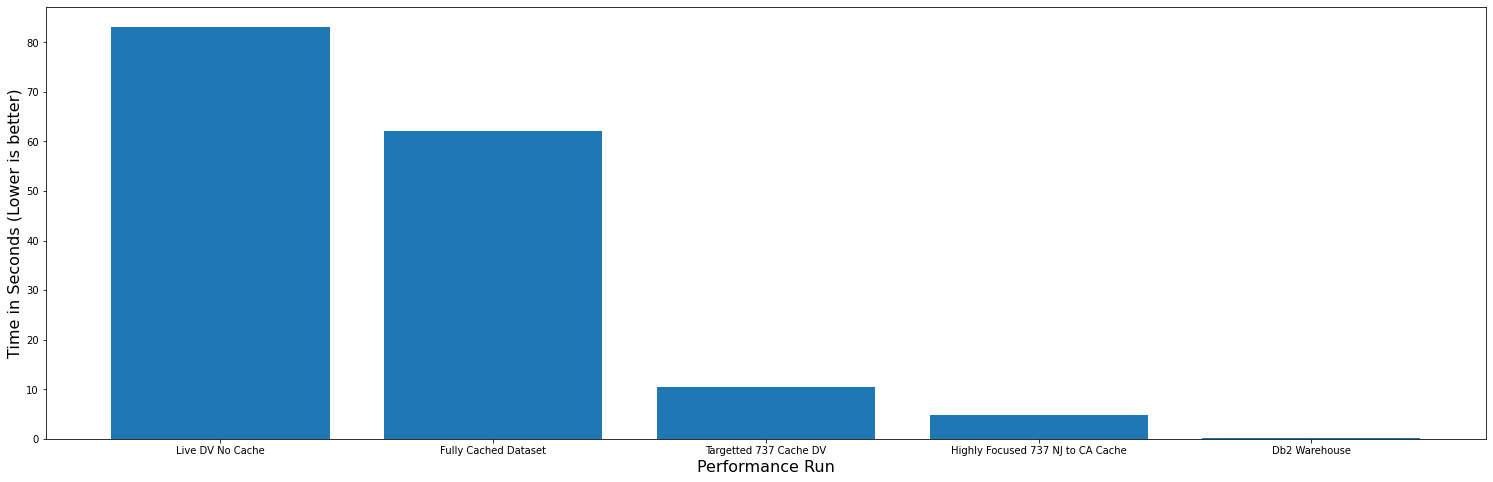

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig = plt.figure(figsize=(20, 6))
ax = fig.add_axes([0,0,1,1])
runs = ['Live DV No Cache','Fully Cached Dataset','Targetted 737 Cache DV','Highly Focused 737 NJ to CA Cache','Db2 Warehouse']
runtime = [dvnocache, dvfullcache, dv737cache, dv737njcacache, db2w]
ax.bar(runs, runtime)
plt.ylabel("Time in Seconds (Lower is better)", fontsize=16)
plt.xlabel("Performance Run", fontsize=16)
plt.show()

In [43]:
print('Aircraft:' + str(aircraft))
print('Number of Domestic Flights in the US')
print('Years 2009 to 2010: ' + str(ontime0910))
print('Years 2011 to 2015: ' + str(ontime1115))
print('Years 2009 to 2015: ' + str(ontimefull))
print('Only 737 from 2009 to 2015: ' + str(ontime737))
print('Only 737 from NJ to CA: ' + str(ontimenjca737))

Aircraft:13101.0
Number of Domestic Flights in the US
Years 2009 to 2010: 12752436.0
Years 2011 to 2015: 30190408.0
Years 2009 to 2015: 42942844.0
Only 737 from 2009 to 2015: 4172450.0
Only 737 from NJ to CA: 37621.0


<Figure size 432x288 with 0 Axes>

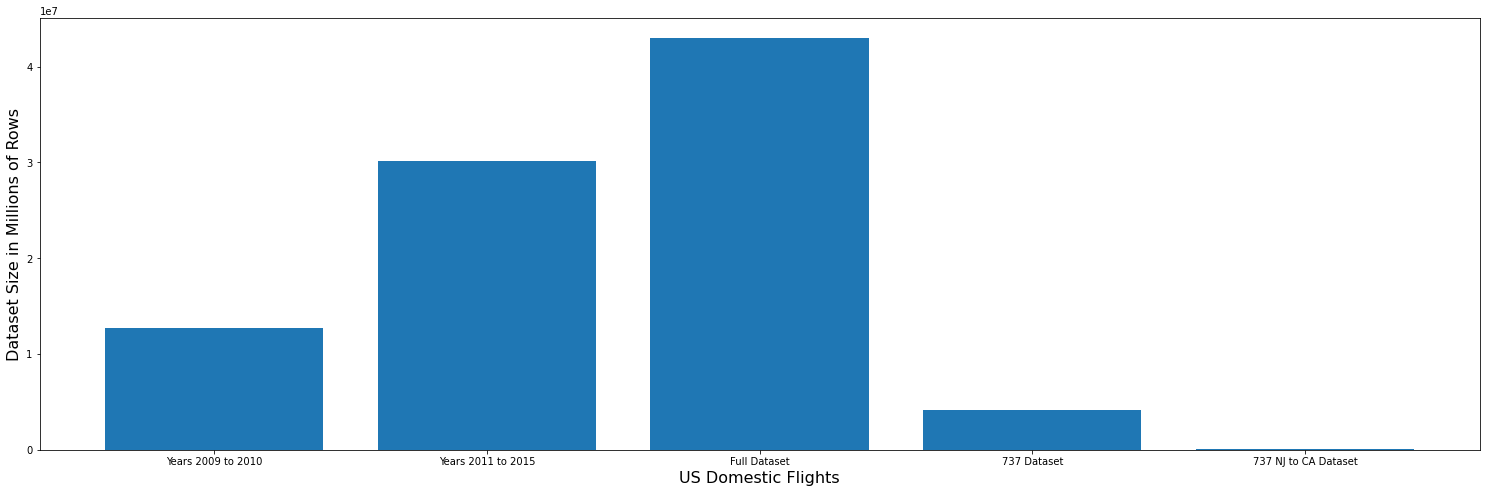

In [44]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig = plt.figure(figsize=(20, 6))
ax = fig.add_axes([0,0,1,1])
runs = ['Years 2009 to 2010','Years 2011 to 2015','Full Dataset','737 Dataset','737 NJ to CA Dataset']
runtime = [ontime0910, ontime1115, ontimefull, ontime737, ontimenjca737]
ax.bar(runs, runtime)
plt.ylabel("Dataset Size in Millions of Rows", fontsize=16)
plt.xlabel("US Domestic Flights", fontsize=16)
plt.show()

## Refreshing a Cache Through a RESTful Service Call

In [ ]:
databaseAPI.refreshCache('DV20211115221309388288')
df = databaseAPI.getCaches("Refreshing")
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

In [ ]:
df = databaseAPI.getCaches("Available")
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

## Get Cache Details

In [ ]:
json = databaseAPI.getCacheDetails('DV20211115221309388288')
print(json)

In [ ]:
print(json['state'])

In [ ]:
display(pd.DataFrame(json_normalize(json))[['name','state']])

In [ ]:
pd.set_option('display.max_rows', 20)
display(pd.DataFrame(json_normalize(json)).T)